# Multi-armedBandits - Chapter 2

## A k-armed Bandit Problem
Bandit problem is a simplified setting for reinforcement learning in which you are faced repeatedly with a choice among k different options (actions).After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total
reward over some time period, for example, over 1000 action selections, or time steps.


In our k-armed bandit problem, each of the k actions has an expected or mean reward given that
that action is selected; let us call this the value of that action. We denote the action selected on time
step t as At , and the corresponding reward as Rt . The value then of an arbitrary **action a**, denoted
q∗ (a), is the **expected reward** given that a is selected:
$$q_{*}(a) = E \{ \ R_t \ | \ A_t=a \} $$

If you knew the value of each action, then it would be trivial to solve the k-armed bandit problem: you
would always select the action with highest value. We assume that you do not know the action values
with certainty, although you may have estimates. We denote the **estimated value** of action a at time
step t as ** $Q_t(a)$ **. We would like $Q_t(a)$ to be close to $q_∗$(a).

If you maintain estimates of the action values, then at any time step there is at least one action whose
estimated value is greatest. We call these the **greedy actions**. When you select one of these actions,
we say that you are **exploiting** your current knowledge of the values of the actions. If instead you
select one of the nongreedy actions, then we say you are **exploring**, because this enables you to improve
your estimate of the nongreedy action’s value. 

**Exploitation** $\to$ Maximize the expected reward on the **one step**.

**Exploration** $\to$ Produce the greater total reward in the **long run**.

Whether it is better to explore or exploit depends in a complex way on the precise values of the estimates, uncertainties, and the number of remaining steps.

In [9]:
import numpy as np
np.warnings.filterwarnings('ignore')
from enum import Enum


class EstimationMethod(Enum):
    """This is an enum for representing different methods of estimating the value of each action"""
    SAMPLE_AVERAGE_INCREMENTAL = 1
    CONSTANT_STEP_SIZE = 2
    GRADIENT_BANDIT = 3


class ActionSelectionMethod(Enum):
    """This is an enum representing different methods of selecting the action"""
    EPSILON_GREEDY = 1
    UPPER_CONFIDENCE_BOUND = 2
    GRADIENT_BANDIT = 3


class Bandit:
    """This class represents a Bandit problem

    k-armed bandit problem is a problem in reinforcement learning with simplified setting. You are
    faced repeatedly with a choice among k different options, or actions. After each choice you
    receive a numerical reward chosen from a stationary probability distribution that depends
    on the action you selected.

    Attributes:
        arms (int) : number of arms of the problem (k)
        estimation_method (EstimationMethod) : the method of estimating the action value
        action_selection_method (ActionSelectionMethod) : the method of selecting next action
        c (float) : it is the coefficient of UCB (c > 0)
        epsilon (float) : it is the probability of acting randomly in epsilon-greedy algorithm
        alpha (float) : is the step size in gradient abd constant step size algorithm
        random_walk (float) : is the standard derivation of normal distribution for adding to Q*
        start_equal (bool) : a boolean representing whether all q* start in equal values (Q*(a)=0)
        initial_value_estimation (float) : initial value for actions estimation value
        q_star_mean (float) : normal distribution with given mean for Q*(a)
        gradient_baseline (bool) : whether the gradient has baseline or not
        time (int) : time step which we are in
        action_probability (np,array) : the probability of choosing each action (gradient algorithm)
        average_reward (float) : average reward until the current time
        q_estimations (np.array) : estimation of values for each action
        action_counts (np.array) : number of times which each action have been chosen
        q_true_values (np.array) : the true value of each action (Q*(a))
    """
    def __init__(self, arms=10, estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL,
                 epsilon=0.1,gradient_baseline=False,alpha=0.1, start_equal=False, random_walk=0,
                 action_selection_method=ActionSelectionMethod.EPSILON_GREEDY, c=2,
                 initial_value_estimation=0.0, start_time=0,q_star_mean=0):

        # parameters
        self.arms = arms
        self.estimation_method = estimation_method
        self.action_selection_method = action_selection_method
        self.c = c
        self.epsilon = epsilon
        self.alpha = alpha
        self.random_walk = random_walk
        self.start_equal = start_equal
        self.initial_value_estimation = initial_value_estimation
        self.start_time = start_time
        self.q_star_mean = q_star_mean
        self.gradient_baseline = gradient_baseline

        # environment
        self.time = self.start_time
        self.action_probability = np.zeros(self.arms)
        self.action_probability.fill(1)
        self.average_reward = 0
        self.q_estimations = np.zeros(self.arms)
        self.q_estimations.fill(self.initial_value_estimation)
        self.action_counts = np.zeros(self.arms)
        self.q_true_values = np.zeros(self.arms)
        if not self.start_equal:
            self.q_true_values = np.random.normal(self.q_star_mean, 1, self.arms)

    def start_new_environment(self):
        """reset all the environment parameters"""
        self.time = self.start_time
        self.action_probability = np.zeros(self.arms)
        self.action_probability.fill(1)
        self.average_reward = 0
        self.q_estimations = np.zeros(self.arms)
        self.q_estimations.fill(self.initial_value_estimation)
        self.action_counts = np.zeros(self.arms)
        self.q_true_values = np.zeros(self.arms)
        if not self.start_equal:
            self.q_true_values = np.random.normal(self.q_star_mean, 1, self.arms)

    def select_action(self):
        """select one of the action according to action selection method"""
        if self.action_selection_method == ActionSelectionMethod.EPSILON_GREEDY:

            if np.random.random_sample() < self.epsilon:
                # select one of the actions randomly
                return np.random.choice(np.arange(self.arms))
            else:
                # argmax by break tie randomly
                return np.random.choice(np.flatnonzero(self.q_estimations==self.q_estimations.max()))

        elif self.action_selection_method == ActionSelectionMethod.UPPER_CONFIDENCE_BOUND:
            ucb_value = self.q_estimations + \
                        self.c * np.sqrt(np.log(self.time) / self.action_counts)
            return np.argmax(ucb_value)

        elif self.action_selection_method == ActionSelectionMethod.GRADIENT_BANDIT:
            exp_h = np.exp(self.q_estimations)
            self.action_probability = exp_h / exp_h.sum()
            return np.random.choice(np.arange(self.arms), p=self.action_probability)

    def step(self, action):
        """simulate one step and return the reward"""
        reward = np.random.normal(self.q_true_values[action], scale=1.0)

        self.time += 1

        self.average_reward = (self.average_reward * (self.time - 1) + reward) / self.time

        self.action_counts[action] += 1

        if self.random_walk != 0:
            mu, sigma = 0, self.random_walk # mean and standard deviation
            self.q_true_values += np.random.normal(mu, sigma, self.arms)

        if self.estimation_method == EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL:
            self.q_estimations[action]+=(reward-self.q_estimations[action])/self.action_counts[action]
        elif self.estimation_method == EstimationMethod.CONSTANT_STEP_SIZE:
            self.q_estimations[action] += self.alpha * (reward - self.q_estimations[action])
        elif self.estimation_method == EstimationMethod.GRADIENT_BANDIT:
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            one = np.zeros(self.arms)
            one[action] = 1
            self.q_estimations -= self.alpha*(reward-baseline)*(self.action_probability-one)
        return reward

    def simulate(self, runs=2000, time_steps=1000):
        """simulate for given number of runs with the given number of time steps"""
        best_action_counts = np.zeros((runs, time_steps))
        rewards = np.zeros((runs, time_steps))

        for r in range(runs):
            self.start_new_environment()
            for t in range(time_steps):
                action = self.select_action()
                reward = self.step(action)
                rewards[r, t] = reward
                if action == np.argmax(self.q_true_values):
                    # it was the best action
                    best_action_counts[r, t] = 1

        # mean of all rewards and best action of all runs count in a particular time step
        return best_action_counts.mean(axis=0), rewards.mean(axis=0)


## Action-value Methods
We begin by looking more closely at some simple methods for estimating the values of actions and for using the estimates to make action selection decisions. Recall that the true value of an action is the mean reward when that action is selected. One natural way to estimate this is by **averaging the rewards** actually received:
$$ Q_t(a) = \frac{sum \ of \ rewards\ when \ a \ taken \ prior \ to \ t}{number \ of \ times \ a \ taken \ prior \ to \ t} = \frac{\sum_{i=1}^{t-1}R_i \ . \ 1_{A_i=a}}{\sum_{i=1}^{t-1} 1_{A_i=a}}$$

*$1_{predicate}$ denotes the random variable that is 1 if predicate is true and 0 if it is not.*

We call this the **sample-average** method for **estimating action values**. Of course this is just one way to estimate action values, and not necessarily the best one.

The simplest action selection rule is to select **one of the actions** with the **highest estimated value**,
that is, one of the greedy actions as defined in the previous section. If there is **more than one greedy
action**, then a selection is made among them in some arbitrary way, perhaps **randomly**. We write this
greedy action selection method as:
$$A_t = argmax \ Q_t(a)$$
A simple alternative is to behave **greedily most of the time**, but every once in a while, say with small
**probability ε**, instead **select randomly from among all the actions** with equal probability, independently
of the action-value estimates. We call methods using this near-greedy action selection rule **ε-greedy**
methods.



<IPython.core.display.Javascript object>


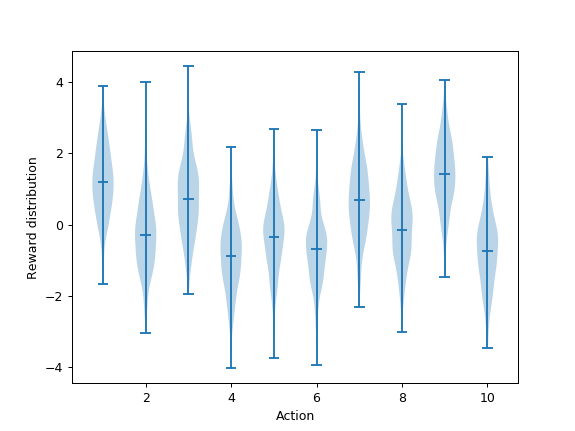

Text(0,0.5,'Reward distribution')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
#Figure 2.1
%matplotlib notebook

#a sample from normal distribution with mean zero and unit variance for each action
q_star_value = np.random.randn(10) 
# a mean q_star_value, unit variance normal distribution
rewards = np.random.randn(500,10) + q_star_value 
plt.violinplot(dataset=rewards , showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward distribution")

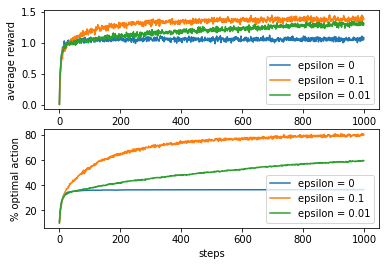

In [4]:
import matplotlib.pyplot as plt

#Figure 2.2
epsilons = [0, 0.1, 0.01]
epsilon_greedy_bandits = [Bandit(arms=10,
                                 estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL,
                                 action_selection_method=ActionSelectionMethod.EPSILON_GREEDY,
                                 epsilon=eps)
                          for eps in epsilons]

epsilon_greedy_best_action, epsilon_greedy_rewards = [], []
for bandit in epsilon_greedy_bandits:
    result = bandit.simulate(2000, 1000)
    epsilon_greedy_best_action.append(result[0])
    epsilon_greedy_rewards.append(result[1])
    
%matplotlib inline
plt.figure()

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, epsilon_greedy_rewards):
    plt.plot(rewards, label='epsilon = {}'.format(eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, epsilon_greedy_best_action):
    plt.plot(counts * 100, label='epsilon = {}'.format(eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

## Incremental Implementation
The action-value methods we have discussed so far all estimate action values as sample
averages of observed rewards. We now turn to the question of how these averages can be
computed in a computationally **efficient** manner, in particular, with **constant memory**
and constant per-time-step computation.

$$Q_n \ = \ \frac{R_1 \ + R_2 \ + \ ... \ + \ R_{n-1}}{n-1}$$

$$Q_{n+1} \ = \ \frac{1}{n} \ \sum_{i=1}^{n} \ R_i$$

$$ = \ \frac{1}{n} \ (R_n \ + \ \sum_{i=1}^{n-1} \ R_i )$$

$$ = \ \frac{1}{n} \ ( \ R_n \ + \ (n-1) \ \frac{1}{n-1} \ \sum_{i=1}^{n-1} \ R_i \ )$$

$$ = \ \frac{1}{n} \ ( \ R_n \ + \ (n-1) \ Q_n \ )$$

$$ = \ \frac{1}{n} \ ( \ R_n \ + \ n Q_n \ - \ Q_n \ )$$

$$ = \ Q_n \ + \ \frac{1}{n} \ [ \ R_n \ - \ Q_n \ ]$$

**NewEstimate <- OldEstimate + StepSize \[ Target - OldEstimatei \]**


## Tracking a Nonstationary Problem
Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the $q_*$(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the $q_*$(a) on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, $\alpha$ = 0.1. Use $\epsilon$ = 0.1 and longer runs, say of 10,000 steps.
 

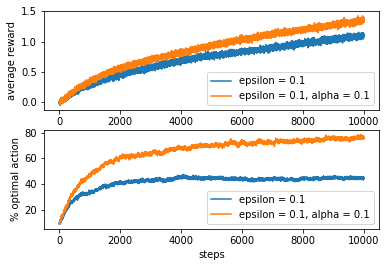

In [5]:
import matplotlib.pyplot as plt

#Exercise 2.5 
sample_average_bandit = Bandit(arms=10,
                               estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL,
                               action_selection_method=ActionSelectionMethod.EPSILON_GREEDY,
                               epsilon=0.1,start_equal=True, random_walk=0.01)

constant_step_size_bandit = Bandit(arms=10, estimation_method=EstimationMethod.CONSTANT_STEP_SIZE,
                                   alpha=0.1,random_walk=0.01,epsilon=0.1, start_equal=True,
                                   action_selection_method=ActionSelectionMethod.EPSILON_GREEDY)

epsilon_greedy_best_action, epsilon_greedy_rewards = [], []

sample_average_result = sample_average_bandit.simulate(2000, 10000)
sample_average_best_action = sample_average_result[0]
sample_average_rewards = sample_average_result[1]

constant_step_size_result = constant_step_size_bandit.simulate(2000, 10000)
constant_step_size_best_action = constant_step_size_result[0]
constant_step_size_rewards = constant_step_size_result[1]

%matplotlib inline
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(sample_average_rewards, label='epsilon = {}'.format(0.1))
plt.plot(constant_step_size_rewards, label='epsilon = {}, alpha = {}'.format(0.1, 0.1))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sample_average_best_action * 100, label='epsilon = {}'.format(0.1))
plt.plot(constant_step_size_best_action * 100, label='epsilon = {}, alpha = {}'.format(0.1, 0.1))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

## Optimistic Initial Values



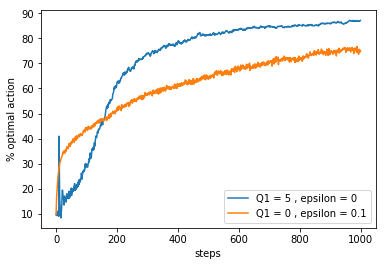

In [7]:
import matplotlib.pyplot as plt

#Figure 2.3
optimistic_initial_value_bandit =Bandit(arms=10,
                                        estimation_method=EstimationMethod.CONSTANT_STEP_SIZE,
                                        alpha=0.1,
                                        action_selection_method=ActionSelectionMethod.EPSILON_GREEDY,
                                        epsilon=0,initial_value_estimation=5.0)

realistic_initial_value_bandit =Bandit(arms=10,
                                       estimation_method=EstimationMethod.CONSTANT_STEP_SIZE,
                                       alpha=0.1,
                                       action_selection_method=ActionSelectionMethod.EPSILON_GREEDY,
                                       epsilon=0.1,initial_value_estimation=0)

optimistic_result = optimistic_initial_value_bandit.simulate(2000, 1000)
optimistic_best_action = optimistic_result[0]

realistic_result = realistic_initial_value_bandit.simulate(2000, 1000)
realistic_best_action = realistic_result[0]

%matplotlib inline
plt.plot(optimistic_best_action * 100, label='Q1 = {} , epsilon = {}'.format(5, 0))
plt.plot(realistic_best_action * 100, label='Q1 = {} , epsilon = {}'.format(0, 0.1))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

## Upper-Confidence-Bound Action Selection


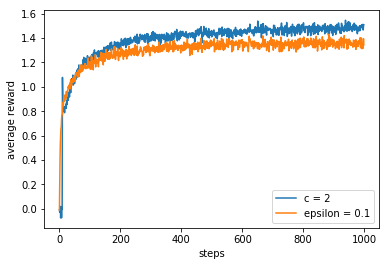

In [10]:
import matplotlib.pyplot as plt

#Figure 2.4
ucb_bandit = Bandit(arms=10, estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL,
                    action_selection_method=ActionSelectionMethod.UPPER_CONFIDENCE_BOUND,
                    c=2, start_time=1)

epsilon_greedy_bandit = Bandit(arms=10, 
                               estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL,
                               action_selection_method=ActionSelectionMethod.EPSILON_GREEDY,
                               epsilon=0.1,
                               start_time=1)

ucb_result = ucb_bandit.simulate(2000, 1000)
ucb_rewards = ucb_result[1]

epsilon_greedy_result = epsilon_greedy_bandit.simulate(2000, 1000)
epsilon_greedy_rewards = epsilon_greedy_result[1]

%matplotlib inline
plt.plot(ucb_rewards, label='c = {}'.format(2))
plt.plot(epsilon_greedy_rewards, label='epsilon = {}'.format(0.1))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

## Gradient Bandit Algorithms


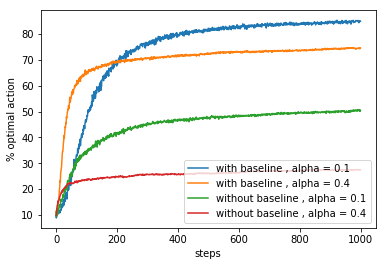

In [12]:
import matplotlib.pyplot as plt

#Figure 2.5
gradient_small_alpha_base_bandit=Bandit(arms=10,
                                        estimation_method=EstimationMethod.GRADIENT_BANDIT,
                                        alpha=0.1,gradient_baseline=True, q_star_mean=4,
                                        action_selection_method=ActionSelectionMethod.GRADIENT_BANDIT)
gradient_small_alpha_base_best_action=gradient_small_alpha_base_bandit.simulate(2000, 1000)[0]

gradient_big_alpha_base_bandit=Bandit(arms=10,
                                      estimation_method=EstimationMethod.GRADIENT_BANDIT,
                                      alpha=0.4,gradient_baseline=True, q_star_mean=4,
                                      action_selection_method=ActionSelectionMethod.GRADIENT_BANDIT)
gradient_big_alpha_base_best_action=gradient_big_alpha_base_bandit.simulate(2000, 1000)[0]

gradient_small_alpha_bandit=Bandit(arms=10, estimation_method=EstimationMethod.GRADIENT_BANDIT,
                                   alpha=0.1, gradient_baseline=False, q_star_mean=4,
                                   action_selection_method=ActionSelectionMethod.GRADIENT_BANDIT)
gradient_small_alpha_best_action=gradient_small_alpha_bandit.simulate(2000,1000)[0]

gradient_big_alpha_bandit = Bandit(arms=10, estimation_method=EstimationMethod.GRADIENT_BANDIT,
                                   alpha=0.4, gradient_baseline=False, q_star_mean=4,
                                   action_selection_method=ActionSelectionMethod.GRADIENT_BANDIT)
gradient_big_alpha_best_action = gradient_big_alpha_bandit.simulate(2000, 1000)[0]

%matplotlib inline
plt.plot(gradient_small_alpha_base_best_action * 100,label='with baseline , alpha = {}'.format(0.1))
plt.plot(gradient_big_alpha_base_best_action * 100,label='with baseline , alpha = {}'.format(0.4))
plt.plot(gradient_small_alpha_best_action * 100, label='without baseline , alpha = {}'.format(0.1))
plt.plot(gradient_big_alpha_best_action * 100, label='without baseline , alpha = {}'.format(0.4))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

## Associative Search (Contextual Bandits)


## Summary


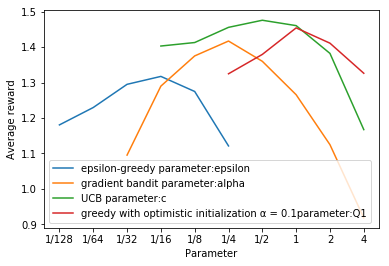

In [13]:
import matplotlib.pyplot as plt

#Figure 2.6
epsilon_greedy_bandits = [Bandit(action_selection_method=ActionSelectionMethod.EPSILON_GREEDY, 
                                 epsilon=2**power,
                                 estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL)
                          for power in range(-7, -1)]

average_rewards_epsilon_greedy = []
for bandit in epsilon_greedy_bandits:
    reward = bandit.simulate(2000,1000)[1].mean()
    average_rewards_epsilon_greedy.append(reward)
gradient_bandit_bandits = [Bandit(action_selection_method=ActionSelectionMethod.GRADIENT_BANDIT,
                                  alpha=2**power,
                                  estimation_method=EstimationMethod.GRADIENT_BANDIT,
                                  gradient_baseline=True) for power in range(-5, 3)]
average_rewards_gradient = []
for bandit in gradient_bandit_bandits:
    reward = bandit.simulate(2000, 1000)[1].mean()
    average_rewards_gradient.append(reward)

ucb_bandits = [Bandit(estimation_method=EstimationMethod.SAMPLE_AVERAGE_INCREMENTAL,
                      action_selection_method=ActionSelectionMethod.UPPER_CONFIDENCE_BOUND,
                      c=2**power,start_time=1) for power in range(-4, 3)]
average_rewards_ucb = []
for bandit in ucb_bandits:
    reward = bandit.simulate(2000, 1000)[1].mean()
    average_rewards_ucb.append(reward)

optimistic_bandits = [Bandit(arms=10, estimation_method=EstimationMethod.CONSTANT_STEP_SIZE,
                             alpha=0.1,
                             action_selection_method=ActionSelectionMethod.EPSILON_GREEDY,
                             epsilon=0,
                             initial_value_estimation=2**power) for power in range(-2, 3)]

average_rewards_optimistic = []
for bandit in optimistic_bandits:
    reward = bandit.simulate(2000, 1000)[1].mean()
    average_rewards_optimistic.append(reward)

%matplotlib inline   
plt.xticks(range(-7, 3), ('1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'))

plt.plot(range(-7, -1), average_rewards_epsilon_greedy, label='epsilon-greedy parameter:epsilon')
plt.plot(range(-5, 3), average_rewards_gradient, label='gradient bandit parameter:alpha')
plt.plot(range(-4, 3), average_rewards_ucb, label='UCB parameter:c')
plt.plot(range(-2, 3), average_rewards_optimistic,
         label='greedy with optimistic initialization α = 0.1parameter:Q1')

plt.xlabel('Parameter')
plt.ylabel('Average reward')
plt.legend()